# 1. Ensemble Learning overview
Classical Machine Learning algorithms are usually shown to be poor when handling real-world datasets. Models fit from these algorithms often suffer from two problems: high bias and high variance; such a model is called a *weak learner*. In this topic, we are going through some elegant techniques that combine multiple algorithms to form a powerful model, which produces an improved overall result. This is referred to generally as [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning). Enemble Learning methods in fact have proved their effectiveness in many Machine Learing competitions.

## 1.1. Voting
[Voting](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier) (for classification) or [Averaging](https://scikit-learn.org/stable/modules/ensemble.html#voting-regressor) (for regression) is the simplest ensembling method. When doing voting for classification, there are two strategies can be applied: marjority voting on predicted results (hard voting) and taking argmax of the weighted average of predicted probabilities (soft voting).

In [11]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, floatmode='maxprec')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, VotingRegressor

In [7]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=7)

In [42]:
clf1 = SVC(probability=True)
clf2 = LogisticRegression(solver='liblinear')
clf3 = DecisionTreeClassifier()

models = [clf1, clf2, clf3]
base_models = [(i.__class__.__name__, i) for i in models]
ensembler = VotingClassifier(base_models, voting='soft')

In [44]:
for model in models + [ensembler]:
    model = model.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    auc = roc_auc_score(yTest, yPred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.8909 [SVC]
AUC = 0.9230 [LogisticRegression]
AUC = 0.8837 [DecisionTreeClassifier]
AUC = 0.9455 [VotingClassifier]


## 1.2. Stacking
[Stacking](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization) technique organizes its members into two levels:
- Level 1, a number of *base models* is fit to ther dataset. Build a new dataset where the values predicted by base models are input variables while the output variable remains the same.
- Level 2, a *meta model* is train on the new dataset to get final prediction.

The idea behind stacking is that each base model has an unique approach, it might discover some parts of the ground truth that other models do hot have. Combining them might utilize the their strengths and thus improve the overall quality. Note that Voting is a special case of Stacking, where the final combiner is a very simple model.

In the implementation of Stacking, the base models are often selected *heterogeneously*, and the meta model is often a simple Logistic Regression model.

In [1]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, floatmode='maxprec')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, StackingRegressor

In [26]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=7)

In [40]:
clf1 = KNeighborsClassifier()
clf2 = GaussianNB()
clf3 = SVC(probability=True)
clf4 = LogisticRegression(solver='liblinear')
clf5 = DecisionTreeClassifier()

models = [clf1, clf2, clf3, clf4, clf5]
base_models = [(i.__class__.__name__, i) for i in models]
meta_model = LogisticRegression()

ensembler = StackingClassifier(base_models, meta_model)

In [41]:
for model in models + [ensembler]:
    model = model.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    auc = roc_auc_score(yTest, yPred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9373 [KNeighborsClassifier]
AUC = 0.9368 [GaussianNB]
AUC = 0.8909 [SVC]
AUC = 0.9230 [LogisticRegression]
AUC = 0.8966 [DecisionTreeClassifier]
AUC = 0.9321 [StackingClassifier]


## 1.3. Bagging
[Bootstrap Aggregating](https://scikit-learn.org/stable/modules/ensemble.html#bagging-meta-estimator) (Bagging) uses averaging/voting method over a number of *homogeneous* weak models in order to reduce variance. Specifically, Bagging is divided into two parts: [bootsrapping](<https://en.wikipedia.org/wiki/Bootstrapping_(statistics)>) and aggregating.

- Boostrapping: The entire dataset is performed random sampling with replacement on both rows and columns. This outputs a number of bootstraps where each of them is different from the others.
- Aggregating: after boostrap samples are generated, they are fit into the weak learners. All the model results will be combined by averaging (for regression) or voting (for classification).

A Bagging ensembler operates as a committee that outperforms any individual weak model. This wonderful effect - *the wisdom of crowds* - can be explained that weak models protect each other from their individual errors. If the members share the same behaviors, they also make the same mistakes. Therefore, the low correlation between weak models is the key. Note that the Bagging method requires the initial sample to be large enough for the bootstrapping step to be statistical significant.

### Random Forest
Random Forest is the implementation of Bagging method on Decision Trees. It can be easily parallelized, does not requires too much hyperparameters tuning and has a decent prediction power. Random Forest is a very popular algorithm, before Boosting methods take the crown.

[Scikit-learn's Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) has the following Bagging hyperparameters, beside the hyperparameters inherited from Decision Tree:

Hyperparameter|Default|Meaning|Usage|
:---|:---|:---|:---|
`n_estimators`|`100`|The number of trees in the forest|Control the complexity of the algorithm. Try increasing this when<br>the model is underfitting, but it will take a longer training time.|
`max_features`|`auto`|The ratio of features used in each tree|Lower values increase bias and reduce variance.|
`max_samples`|`None`|The ratio of instances used in each tree|Lower values increase bias and reduce variance.|

In [46]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, floatmode='maxprec')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [35]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=7)

In [47]:
clf = RandomForestClassifier(
    n_estimators=20,
    min_samples_split=20,
    max_depth=16,
#     class_weight={0:1, 1:20}
)

clf = clf.fit(XTrain, yTrain)

yPred = clf.predict(XTest)
auc = roc_auc_score(yTest, yPred)

print(f'AUC = {auc:.4f} [{clf.__class__.__name__}]')

AUC = 0.9325 [RandomForestClassifier]


### Implementation

In [34]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, BaggingRegressor

In [35]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=7)

In [37]:
base_model = LogisticRegression(solver='liblinear', class_weight={0:1, 1:10})
ensembler = BaggingClassifier(base_model, 10, random_state=7)

In [38]:
models = [base_model, ensembler]
for model in models:
    model = model.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    auc = roc_auc_score(yTest, yPred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.8957 [LogisticRegression]
AUC = 0.9048 [BaggingClassifier]


## 1.4. Boosting
[Boosting](<https://en.wikipedia.org/wiki/Boosting_(machine_learning)>) works in the same spirit as Bagging: it also build a group of *homogeneous* models to obtain a more powerful predictor. The difference is that Boosting trains weak models sequentially while Bagging perform the training independently. The idea behind Boosting is to fit models iteratively such that the training of each model depends on the previous ones. Using this strategy, badly handled observations in the earlier steps will be taken care better in the later steps. Since the Boosting method puts its efforts on important cases, we end up have a strong learner with lower bias.

In applications, Boosting methods used on Decision Trees are so effective for tabular datasets and is widely used by top competitors. For the rest of this article, we will go through a bunch of interesting Boosting algorithms. To start off, this section discuss the first successful method in the Boosting family, [Adaptive Boosting](https://en.wikipedia.org/wiki/AdaBoost) (AdaBoost).

AdaBoost was originally designed for binary classification problems. This method can be used to boost any algorithm, but Decision Tree is always the go-to choice. More specifically, Decision Trees used here are very shallow, they only have one root and two leaves, explaining why they are also called Decision Stumps.

### AdaBoost
AdaBoost takes the following inputs:
- A dataset having $N$ observations $(\mathbf{X},\mathbf{y})=\{(\mathbf{x}_n,y_n)\}_{n=1}^N$ where $y_n\in\{-1,1\}$
- The number of weak models, $T$
- The learning rate, $\eta$

The algorithm:

*Step 1.* Initialize the weight for each observation: $w_n^{(1)}=1/N$.

*Step 2.* For $t=1,2,\dots,T$:

   - Train a weak model $\hat{y}_n=f_t(\mathbf{x}_n)$ that minimizes the sum of weights over misclassifications, represented by the error:
   
   $$\displaystyle{\epsilon_t=\sum{w_n^{(t)}\;\left[\hat{y}_n\neq y_n\right]}}$$

   - Calculate $\alpha_t$ the amount of say for the current weak classifier; deciding how much $f_t$ will contribute in the final prediction. This calculation rewards $f_t$ a very high influence if its total error is low and penalizes $f_t$ a negative influence for a high total error.
   
   $$\displaystyle{\alpha_t=\frac{\eta}{2}\,\ln{\frac{1-\epsilon_t}{\epsilon_t}}}$$
   
   - Update sample weights for the next iteration so that: the weights of the correctly classied samples decrease $\exp{(\alpha_t)}$ times and the weights of misclassifications increase the same amount. Note that the term $-\hat{y}_n y_n$ equals to $1$ if the prediction is correct and equals to $-1$ if the prediction is incorrect.
   
   $$w_n^{(t+1)}=w_n^{(t)}e^{(-\hat{y}_n y_n)\,\alpha_t}$$
   
   - Normalize new weights so that they add up to $1$. This step is required to make the calculation of $\alpha_{t+1}$ meaningful. At this step, some implementations resample the dataset so that the distribution of observations follows the newly calculated weights.

*Step 3.* Build an additive strong model $F(\mathbf{x})$ that performs weighted voting over $T$ weak learners; this is the output of the algorithm. The formula uses the notation $\text{sign}(\bullet)$, indicating the [sign function](https://en.wikipedia.org/wiki/Sign_function).

$$F(\mathbf{x})=\text{sign}\left(\sum_{t=1}^T\alpha_t f_t(\mathbf{x})\right)$$

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

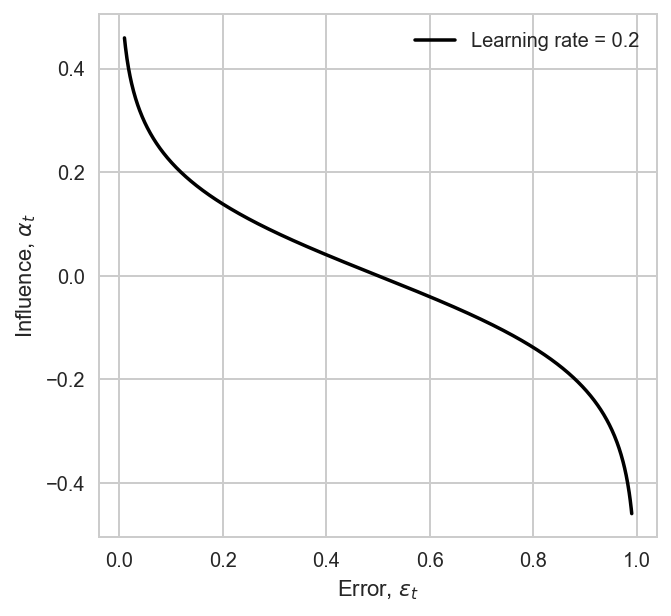

In [50]:
eta = 0.2
x = np.linspace(0.01, 0.99, 1000)
y = eta * 1/2 * np.log(1/x - 1)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x, y, 'k', label=fr'Learning rate = {eta}')
ax.axis('scaled')
ax.set_xlabel(r'Error, $\epsilon_t$')
ax.set_ylabel(r'Influence, $\alpha_t$')
ax.legend()
plt.show()

### Implementation
[Scikit-learn's AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) has the following hyperparameters:

Hyperparameter|Default|Meaning|Usage|
:-|:-|:-|:-|
`base_estimator`|`None`|The algorithm to be boosted|
`n_estimators`|`50`|The number of weak learners, $T$|
`learning_rate`|`1`|The learning rate, $\eta$

In [1]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

In [2]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=7)

In [4]:
base_model = DecisionTreeClassifier(max_depth=1)
ensembler = AdaBoostClassifier(base_model, n_estimators=50, learning_rate=1)

In [6]:
models = [ensembler]
for model in models:
    model = model.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    auc = roc_auc_score(yTest, yPred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9502 [AdaBoostClassifier]


# 2. Gradient Boosting Machine
[Grandient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is another boosting strategy beside Adaptive Boosting. The idea of this method is mostly inspired by [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent), thus the name Gradient Boosting. Just like other ensembling methods, this algorithm works best on Decision Trees and becomes the foundation for its modern variants such as XGBoost, LightGBM and CatBoost.

## 2.1. The algorithm
Gradient Boosting Trees was originally designed for regression problems. The algorithm considers the following inputs:
- A dataset having $N$ observations $(\mathbf{X},\mathbf{y})=\{(\mathbf{x}_n,y_n)\}_{n=1}^N$
- The number of weak models, $T$
- The learning rate, $\eta$
- A [differentiable](https://en.wikipedia.org/wiki/Differentiable_function) loss function $L(y,F(\mathbf{x}))$ ([MSE](https://en.wikipedia.org/wiki/Mean_squared_error) is a popular choice)

The algorithm:

*Step 1.* Initialize the prediction as a constant. Since this is the very first prediction and will be updated step-by-step, we denote this value $F_0({\mathbf{x}})$. When the loss function is MSE, this value is nothing but the mean of $\mathbf{y}$.

$$F_0(\mathbf{x})=\underset\gamma{\arg\min}\sum_{n=1}^NL(y_n,\gamma)$$

*Step 2.* For $t=1$ to $T$:

   - Compute the psuedo-residual $r_n^{(t)}$ equals to the derivative of the loss function with respect to the prediction of the iteration $t-1$. When MSE is used, this term is proportional to the actual residual, $y_n-F(\mathbf{x}_n)$. Thus, we call it psuedo-residual for generalization, allowing plugging if different loss functions.
   
   $$r_n^{(t)}=-\left[\frac{\partial L(y_n,F(\mathbf{x}_n))}{\partial F(\mathbf{x}_n)}\right]_{F(x)=F_{m-1}(x)}$$

   - Fit a weak learner $f_t(\mathbf{x})$ using the training set $\{(\mathbf{x}_n,r_n^{(t)})\}_{n=1}^N$. This step results in a tree with $J_t$ leaf nodes; it means the input space is split into $J_t$ [disjoint](https://en.wikipedia.org/wiki/Disjoint_sets) regions, each region is denoted $R_j\;(j=1,2,\dots,J_t)$. Trees in this step is not restricted to be stumps as in AdaBoost.
   
   - Compute $\gamma_j^{(t)}$, the predicted value for the model $f_t$. By using first-order [Taylor approximation](https://en.wikipedia.org/wiki/Taylor_series), it can be proved that $\gamma_j^{(t)}$ is proportional to the negative gradient $r_n^{(t)}$. When MSE is chosen as the loss function, $\gamma_j^{(t)}$ is the average residual in the leaf $R_j$. As $\gamma_j^{(t)}$ is added to the final prediction $F$ at each iteration, this can be considered a Gradient Descent algorithm.
   
   $$\gamma_j^{(t)}=\underset\gamma{\arg\min}\sum_{\mathbf{x}_n\in R_j}{L(y_n,F_{t-1}(\mathbf{x}_n)+\gamma)}$$
   
   - Update the strong model $F_t$ by adding the current weak predictor scaled by the learning rate. The formula uses the [indicator notation](https://en.wikipedia.org/wiki/Indicator_function).
   
   $$F_t(x)=F_{t-1}(x)+\eta\sum_{j=1}^{J_t}{\gamma_j^{(t)}\mathbf{1}_{R_j}(x)}$$
   
*Step 3*. Take the last strong model as the final predictor: $F\leftarrow F_t$. Note that in Gradient Boosting, the $t^{th}$ learner $F_t$ has taken into account all  weak learners up to the current iteration. Not like in Adaptive Boosting, the strong model is only built once all weak leaners was trained successfully.

## 2.2. Implementation
[Scikit-learn's Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) considers the following hyperparameters (excluding the ones come from Decision Tree). Scikit-learn also introduces the [Histogram-based Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) which is inspired by LightGBM and is much more faster than the original implementation.

Hyperparameter|Default|Meaning|Usage|
:---|:---|:---|:---|
`loss`|`deviance` (classifification)<br>`squared_error` (regression)|The loss function||
`n_estimators`|`100`|The number of boosting stages ($T$)||
`learning_rate`|`0.1`|The learning rate ($\eta$)|
`subsample`|`1.0`|The ratio of instances used in each tree|Lower values increase bias and reduce variance|
`max_features`|`None`|The ratio of features used in each tree|Lower values increase bias and reduce variance|
`criterion`|`friedman_mse`|The mearsure quality of split||

In [2]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, floatmode='maxprec')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

In [4]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=7)

In [6]:
clf1 = GradientBoostingClassifier()
clf2 = HistGradientBoostingClassifier()
models = [clf1, clf2]

for model in models:
    model = model.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    auc = roc_auc_score(yTest, yPred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9775 [GradientBoostingClassifier]
AUC = 0.9455 [HistGradientBoostingClassifier]


# 3. XGBoost

## 3.1. The algorithm

In [32]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, floatmode='maxprec')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier, XGBRegressor

In [9]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=7)

In [37]:
clf = XGBClassifier(eval_metric='error', use_label_encoder=False)

model = clf.fit(XTrain, yTrain)
yPred = model.predict(XTest)
auc = roc_auc_score(yTest, yPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9636 [XGBClassifier]


## 3.2. Implementation

# 4. LightGBM
[LightGBM](https://lightgbm.readthedocs.io/en/latest/) is an implementation of Gradient Boosting developed by Microsoft in order to deal with large datasets. According to [LightGBM paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf), *the main cost in GBDT lies in learning the decision trees, and the most time-consuming part in learning a decision tree is to find the best split points*. XGBoost has developed histogram-based split finding that reduces the complexity of the algorithm from $O(\#instance \times \#feature)$ to $O(\#bin \times \#feature)$ where $\#bin\ll \#instance$, which outperforms other implementations in terms of memory consumption.

However, XGBoost still does not meet the satisfactory of scalability when working on large datasets. To improve the performance of previous implementations, LightGBM introduces two novels techniques, *Gradient-based One-Side Sampling* (GOSS) for reducing data instances and *Exclusive Feature Bundling* (EFB) for reducing data dimensions.

## 4.1. The algorithm

### Gradient-based one-side sampling
As the purpose of GOSS is to smartly sample data, it requires sample weights to achieve this. Althought Gradient Boosting does not have any native weight as in Adaptive Boosting, we can use residuals (generally gradients) as pseudo-weights. The GOSS algorithm is implemented right before the training of each weak learner and is described as follows.

*Input:*
- A dataset of $N$ observations and their corresponding gradients computed from the most recent predictor
- $a$ - the sampling ratio of large gradient data and $b$ - the sampling ratio of small gradient data ($a+b$ should not be greater than $1$)

*Step 1:* Sort (in descending order) the observations by the absolute values of their gradients and select top $\lfloor aN \rfloor$ observations. This under-trained set is what the training of the next tree should focus on.

*Step 2:* Perform random sampling $\lfloor bN \rfloor$ observations from the rest of the data. In order to compensate the information losses that affect data distribution, each instance in this well-trained set is amplified by a constant $\frac{1-a}{b}>1$ when calculating information gain in the next tree.

*Step 3:* Combine the under-trained set and the well-trained set above to form a single set to be used in learning the Decision Tree. By using this technique, *we put more focus on the under-trained instances without changing the original data distribution by much*.

### Exclusive feature bundling

## 4.2. Implementation

In [27]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, floatmode='maxprec')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, LGBMRegressor

In [9]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=7)

In [29]:
clf = LGBMClassifier()

model = clf.fit(XTrain, yTrain)
yPred = model.predict(XTest)
auc = roc_auc_score(yTest, yPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9364 [LGBMClassifier]


# 5. CatBoost

## 5.1. The algorithm

### Target encoding

### Ordered boosting

## 5.2. Implementation

In [38]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, floatmode='maxprec')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, CatBoostRegressor

In [9]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=7)

In [17]:
clf = CatBoostClassifier()

model = clf.fit(XTrain, yTrain, logging_level='Silent')
yPred = model.predict(XTest)
auc = roc_auc_score(yTest, yPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9636 [CatBoostClassifier]


# References
- [Scikit-learn] [Ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html)
- [XGBoost] [Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html)
- [Towards Data Science] [Ensemble methods: bagging, boosting and stacking](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)


- [Paper] [A short introduction to Boosting](http://www.cs.columbia.edu/~jebara/6772/papers/IntroToBoosting.pdf)
- [Paper] [XGBoost: A scalable tree boosting system](https://arxiv.org/pdf/1603.02754.pdf)
- [Paper] [LightGBM: A highly efficient Gradient Boosting Decision Tree](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
- [Paper] [CatBoost: Unbiased Boosting with categorical features](https://arxiv.org/pdf/1706.09516.pdf)

# Old

## XGBoost

**Signing**:
- $O_{value}$: Output value
- $\lambda$ : Regulaziration parameter
- $\gamma$: Tree complexity parameter
- $\eta$: Learning rate
- Gradient ($g$): First derivative of loss function
- Hessian ($h$): Second derivative of loss function
- Residual :$r$
- Number of residual: $N_r$

### The idea and mathematical behind xgboost

The first step of fitting XGboost to the training data is making the initial prediction $p_0$ (default is `0.5` for both regression and classification). Like GBM, XGboost fit a tree to the residual of each observation but each tree in XGboost is unique. XGB build a tree which try to minimize the equation:
$$\sum_{i=1}^{n}L(y_i,p_{i}^0+O_{value}) + \frac{1}{2}\lambda*{O^2_{value}}  \space \mbox{(1)}$$
with $L$ is *loss function* and ($\frac{1}{2}\lambda*{O^2_{value}}$) is *regularization term*.\
The goal of XGB is finding the optimal output value to minimize the equation $(1)$.

To make an Xgboost tree, firstly we calculate the residuals of each obs different to initial prediction then making similariry score for the root:
$$\mbox{Similariry Score} = \frac{(\sum gradient)^2}{\sum hessian + \lambda}$$
Similarity score tell us the similarity between residual of observations, if residuals is different, they cancel out the others so that the similarity score will be small. And $\lambda$ is the regularization parameter, it's intend to reduce the prediction's sensitivity to individual observations and then prevent overfitting. When $\lambda$ increase, the similarity score wil be decrease - the amount of decrease is inversely proportional to the number of residual in the node.\
After having the similarity for the root, we find an optimal split point for the tree. We'll choose one threshold to split the obs and then calculating similarity score for each node. To quantify how much better the leaves similar residual than the root, we calculate the gain:
$$\mbox{gain} = \mbox{left}_{similarity} + \mbox{right}_{similarity} - \mbox{root}_{similarity}$$

We can compare the gain of this thresold to the others and the threshold which made the largest gain will be chosen. Continue building tree with other feature until getting the maximum split.

Now we have the full tree, to prune the tree, we use $\gamma$ parameter. If $gain - \gamma < 0$, we prune that leave.

Next step is find the output for each leaf of the tree. To do that, we derivate the equation $(1)$ and we get the formular for optimal output:
$$O_{value}=\frac{-\sum gradient}{\sum hessian + \lambda}$$

The larger $\lambda$, the closer output value to 0.\
Finally, we use the output value plus learning rate to make the new prediction:
$$p_0 + \sum_{m=1}^{m}\eta * O_{value}$$

Like GBM, the process go on with the next tree which is build based on residual of previous tree. And ending by reaching the smallest residual or maximum tree.


### Application in regression

In regression, XGB use loss function just like GBM:
$$L(y_i,p_i) = \frac{1}{2}(y_i-p_i)^2$$

Then gradient and hessian of loss function is :
$g_i = -(y_i-p_i)$ and $h_i = 1$

Replace to $O_{value}$ and similarity score we will have:
$$O_{value} = \frac{\sum r}{N_r + \lambda}$$

$$\mbox{similarity score} = \frac{\sum r^2}{N_{r} + \lambda} $$

### Application in classification

In classification, the loss function is the negative likelihood:
$$L(y_i,p_i) = -[y_i*log(p_i) + (1-y_i)*log(1-p_i)]$$
Then gradient and hessian of loss function is: 
$g_i = -(y_i-p_i)$ and $h_i = p_i*(1-p_i)$

Replace we have:
$$O_{value} = \frac{\sum r}{N_r + \lambda}$$

$$\mbox{similarity score} = \frac{\sum r^2}{cover+ \lambda} $$
with $Cover = \sum h_i= \sum[\mbox{previous prob}*(1-\mbox{previous prob})]$ 

Despite making probability as a new prediction, we predict $log(odds)$ of prediction then convert to probability (because ouput value is the $log(odds)$ now):

$$log(odds) prediction = log(\frac{p_0}{1-p_0}) + \eta*O_{value}$$

## LightGBM

LightGBM is a gradient boosting framework which use tree based learning algorithm. 

The reason why lightgbm became powerful are:
1. Optimization in accuracy: 
- LigthGBM uses *leaf_wise* stategy to grow the tree vertically. It will choose the leaf with max delta  loss to grow. 
- Optimal split for category feature. Other boosting can only use one-hot encoding for category feature but lightGBM can treat feature values equally although values in numeric (i.e: gender 0-unknow, 1-man, 2-woman)
2.  Optimization in speed and memory usage: 
- LightGBM uses histogram-based algorithms, which bucket continuous feature values into discrete bins. Algo will find the best split between bins.
- LightGBM uses Gradient-based one side sampling (GOSS) method. By usual, subsample process is done by taking random sample from dataset. But GOSS not only perform a faster way to do this but also keep distribution of the data. The instances with larger gradients (under-trained), contribute a lot more to the tree building process so we keep all instances with large gradient, but to prevent changing the distribution, we need to perform random sampling on instances with small gradients. Assume we have 
$n$ data instances, if we keep $a$ instances with large gradients and randomly samples $x$% $(n-a)$ instances with small gradients, we have the sampled data with size $a+ x$% $*(n-a)$. 
3. Sparse Optimization:
- LightGBM handle sparse data by using Exclusive feature bundling (EFB). EFB is a technique that uses a greedy algorithm to combine (or bundle) these mutually exclusive (means never take non-zero in the same time) into a single feature and thus reduce the dimensionality.
4. Optimization in Distributed Learning:
- Distributed learning allows the use of multiple machines to produce a single model.
- Feature parallel: Data had split vertically, each worker handle a subset of feature to find the best split on local feature set then they communicate to others to get the best one. 
- Data parallel: Data had split horizontally, each worker will construct the local histograms then merge them to make global histogram of the data and find the best split on global histogram. 
- Voting parallel: It is the special case of data parallel when communication cost is constant.

||Data is small| Data is large
|:--|:--|:--
**Feature  is small**|Feature parallel|Data parallel|
**Feature is large**|Feaure parallel|Voting parallel|

LightGBM also supports GPU learning. The disadvantage of LGBM is it can easily overfit with small dataset and can't be use with one-hot encoding because of optimal category feature


Implementation

*Reference*: [LightGBM docs](https://lightgbm.readthedocs.io/en/latest/Parameters.html)\
There are several parameters in LGBM which separate into groups:
1. Core parameters
- task: Type of task which perform on your data. Default is `train`, common is `train`/`predict`
- object: Type of problem - regression, binary or multiclass. Default is `regression`.
- boosting: Type of algorithms. Default is `GDBT`. Common value is `GOSS`.
- num_iterations: Number of interation. Default is 100
- learning_rate: Default is `0.1`. Common values are `0.001`, `0.003`
- num_leaves: Max number of leaves in full tree. Default is `31`
- tree_learner: type of distributed learning. Default is `serial`. Common values are: `feature`,`data`,`voting`.
- device_type: `cpu` or `gpu`. GPU can perform better than CPU
- data: path of training data
- valid: path of validation data. Support multiple validation data
2. Learning control parameter
- max_depth: The maximum depth of tree. Default is `-1` means no limit.
- min_data_in_leaf: The minimum observations a leaf. Default is `20`
- feature_fraction: Subset of feature in each tree. Default is `1.0`
- bagging_fraction: Subsample data. Default is `1.0`
- early_stopping_round: Model will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds. Default is `0`.
- lambda: lambda specifies regularization (L1/L2). Default is `0.0`
- min_gain_to_split:the minimal gain to perform split. Default is `0.0`
- max_cat_threshold:Limit number of split points considered for categorical features. Default is `32`
3. IO parameter
- max_bin: Max number of bins that feature values will be bucketed in. Default is `255`
- categorical_feature: used to specify categorical features. Fill with index or name of columns.
- is_enable_sparse: used to enable/disable sparse optimization. Default is `true`
- enable_bundle: used EFB to bunlding feature. Default is `true`
- weight_column: used to specify the weight column. Fill with index or name of column
- save_binary: if true, LightGBM will save the dataset (including validation data) to a binary file. This speed ups the data loading for the next time. Default is `true`
4. Metric parameter
- metric: metric(s) to be evaluated on the evaluation set(s). Default is `""`. Common values are `mae`,`mse`,`auc`,`binary_logloss`,..


In [4]:
import lightgbm as lgbm

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
credit = pd.read_excel('data/credit_scoring.xlsx')
credit = credit.dropna().reset_index()
credit.head()

,index,Bad_customer,credit_balance_percent,age,num_of_group1_pastdue,debt_ratio,income,num_of_loans,num_of_times_late_90days,num_of_estate_loans,num_of_group2_pastdue,num_of_dependents
0,0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
y = credit.Bad_customer.values
x = credit.drop(columns='Bad_customer')

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [8]:
d_train = lgbm.Dataset(x_train, label=y_train)

In [ ]:
params = {
    'learning_rate': [0.001],
    'boosting_type': 'goss',
    'objective': [1],
    'criterion':['friedman_mse']
#     'min_sample_split':[10,5,2]  
}

gbm = GradientBoostingClassifier()
gbm = GridSearchCV(gbm, params, cv=3)
gbm = gbm.fit(x_train, y_train)
gbm.best_params_

In [ ]:
y_train_pred = gbm.predict(x_train)
y_test_pred = gbm.predict(x_test)

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*